# Microgrid with PV, battery and Diesel generator

In [19]:
using Microgrids
using CSV, DataFrames, Statistics

In [9]:
using PyPlot # For plotting only. Can be skipped or commented out

In [7]:
with_plots = isdefined(Main, :PyPlot)

true

## Load time series data

Importing load and solar data

In [21]:
data = DataFrame(CSV.File("$(@__DIR__)/data/Ouessant_data_2016.csv"))

# Simulation steps
ntimestep = length(data.Load)

# Split load and solar data:
Pload = data.Load # kW
Ppv1k =  data.Ppv1k ./ 1000; # convert to kW/kWp
mean(Ppv1k) # yearly capacity factor of 12% (quite low in 2016 in Ouessant)

0.1182560696347032

Display input time series

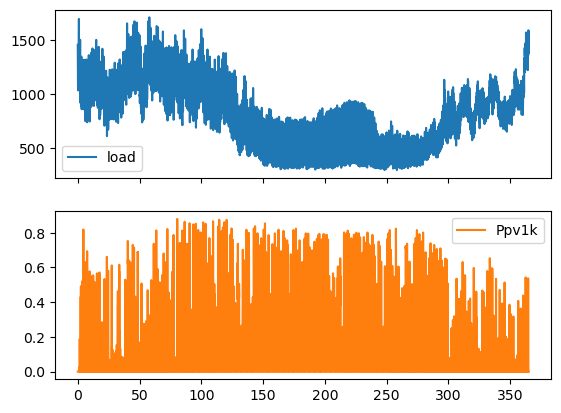

PyObject <matplotlib.legend.Legend object at 0x7f3706a77910>

In [23]:
t = collect((0:ntimestep-1)/24)

if with_plots
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=true)
    ax1.plot(t, Pload, label="load")
    ax1.legend()
    ax2.plot(t, Ppv1k, "C1", label="Ppv1k")
    ax2.legend()
end

## Microgrid simulation

### Create project and its components

Project

In [24]:
lifetime = 25 # yr
discount_rate = 0.05
timestep = 1 # h

project = Project(lifetime, discount_rate, timestep)

Project(25, 0.05, 1)

Photovoltaic

In [25]:
power_rated_PV = 6000 # kW
fPV = 1.
IT = Ppv1k
IS = 1.0
investiment_cost_PV = 1200.
om_cost_PV = 20.  
replacement_cost_PV = 1200.
salvage_cost_PV = 1200.
lifetime_PV = 25

photovoltaic = Photovoltaic(power_rated_PV, fPV, IT, IS, investiment_cost_PV, om_cost_PV, replacement_cost_PV, salvage_cost_PV, lifetime_PV)

Photovoltaic(6000, 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1.0, 1200.0, 20.0, 1200.0, 1200.0, 25)

Battery

In [26]:
energy_initial = 0.
energy_max = 9000
energy_min = 0
power_min = -1.0*energy_max
power_max = +1.0*energy_max
loss = 0.05
investiment_cost_BT = 350.
om_cost_BT = 10.
replacement_cost_BT = 350.
salvage_cost_BT = 350.
lifetime_BT = 15
lifetime_thrpt = 3000

battery = Battery(energy_initial, energy_max, energy_min, power_min, power_max, loss, investiment_cost_BT, om_cost_BT, replacement_cost_BT, salvage_cost_BT, lifetime_BT, lifetime_thrpt)

Battery(0.0, 9000, 0, -9000.0, 9000.0, 0.05, 350.0, 10.0, 350.0, 350.0, 15, 3000)

Diesel generator

In [27]:
power_rated_DG = 1800.
min_load_ratio = 0
F0 = 0.0
F1 = 0.240
fuel_cost = 1.
investiment_cost_DG = 400.
om_cost_DG = 0.02
replacement_cost_DG = 400.
salvage_cost_DG = 400.
lifetime_DG = 15000

dieselgenerator = DieselGenerator(power_rated_DG, min_load_ratio, F0, F1, fuel_cost, investiment_cost_DG, om_cost_DG, replacement_cost_DG, salvage_cost_DG, lifetime_DG)

DieselGenerator(1800.0, 0, 0.0, 0.24, 1.0, 400.0, 0.02, 400.0, 400.0, 15000)

Microgrid

In [28]:
microgrid = Microgrid(project, Pload, dieselgenerator, battery, [photovoltaic]);

### Simulate the microgrid

In [38]:
opervarstraj, opervarsaggr, costs = simulate(microgrid);

#### Costs

`costs` output is of type `MicrogridCosts`, with fields such as `lcoe` and a detailed cost break down

In [49]:
costs.npc/1e6 # M$

28.353000758421675

In [37]:
costs.lcoe # $/kWh

0.28279336653813697

#### Operational statistics

`opervarsaggr` is of type `OperVarsAgg` with fields such as `renewables_rate`, `shedding_rate`...

In [39]:
opervarsaggr.renewables_rate # %

58.74028997693115

In [47]:
opervarsaggr.fuel_consumption # liters

670880.8054857135

In [46]:
opervarsaggr

OperVarsAggr(6.774979e6, 0, 0, 0, 0.0, 3327, 670880.8054857135, 1.881753568922309e6, 4569.3, 58.74028997693115)

#### Operational trajectories

`opervarstraj` is of type `OperVarsTraj` with fields such as `Pgen` (generator power), `Pbatt` (battery power)...

### Display operation trajectories

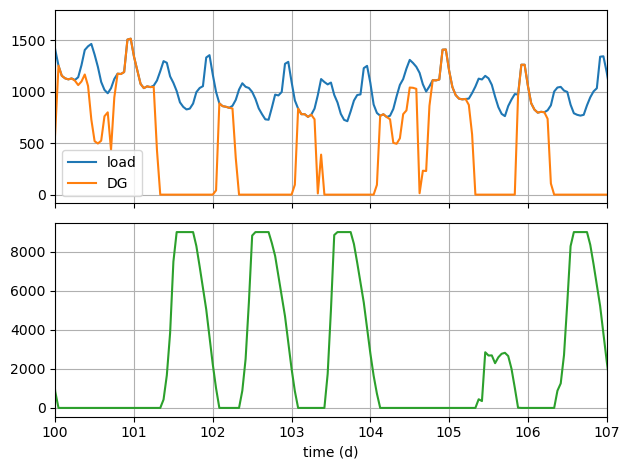

In [42]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=true)
ax1.plot(t, Pload, label="load")
ax1.plot(t, opervarstraj.Pgen, label="DG")
#ax1.plot(t, opervarstraj.Pbatt)
ax2.plot(t, opervarstraj.Ebatt[1:end-1], "C2")

ax1.legend()
ax1.grid(true)
ax2.grid(true)
ax2.set(
    xlabel="time (d)"
)

d0 = 100
plt.xlim(d0,d0+7)
fig.tight_layout()

## Microgrid sizing optimization

DRAFT

### How it is done now 

Manually recreate components by mixing input components and input x

(rough sketch)

In [ ]:
function obj(x)
    dg = DG(a,b,c, x[1])
    mg = MG(dg)
    simulate(mg)
    return results

In [ ]:
pv = microgrid.nondispatchables[1]

### How we would like it to be

dynamically select which variables are optimized

In [ ]:
opti_params = [
    ([:dieselgenator,:power_rated], 1800.0),
    ([:battery,:energy_max], 1800.0)
]
optimize(mg0, opti_params)

In [ ]:
function set_field(component, name, value)
    "something like component.$name = value, but for immutable Type"

In [41]:
name = :power_rated
getproperty(dieselgenerator, name)

1800.0

In [71]:
getproperty(getproperty(microgrid, :dieselgenerator), name)

1800.0